# Genetrator of Halpha,21cm and dust snapshots to be fed to SKIRT and subsequent analysis of the SKIRT oputput
For the Halpha, it creates 3D snapshot of emissivity + dust distribution to scatter it upon with SKIRT.
For the 21cm, since the photodissociation of H2 is simulated in TIGRESS, it creates the centimetric radio flux maps.
For the dust maps, it creates 3D snapshots of stars + old star disk + dust distribution to run the SKIRT model with.

# Importing the snapshots

In [1]:
# Importing the paths of the first snapshot of the simulation
# Importing the snapshot class and the units

import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy.io import fits
from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from matplotlib.colors import LogNorm
from scipy.ndimage import shift
from pyathena.util.expand_domain import expand_xy
from scipy.integrate import quad
import matplotlib.transforms as transforms
from matplotlib.transforms import Bbox
from collections import Counter
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy.ndimage import shift

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir_Halpha = '/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/'
output_dir_HI = '/export/home/extragal/francesco.chititegli/TIGRESS_1/H21maps/'
output_dir_IR = '/export/home/extragal/francesco.chititegli/TIGRESS_1/IRmaps/'
output_dir_exp = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded/'
tigress_dir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/'
gallery_dir = '/export/home/extragal/francesco.chititegli/GALLERY/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.


xi_CR0 not found. Use 2e-16.


In [2]:
# Lenghts are already in pc, Velocities are already in km/s, Temperatures are already be in K
# Gas cells' mass densities are already in g/cm3, and numeric densities are already in 1/cm3

time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134
dust_to_gas_ratio = 0.01
h_alpha_wave = 0.65628 # (micron)
h_alpha_energy = 3.03e-12 # (erg)
H_mass = 8.41e-58 # (Msun)
H_mass_grams = 1.67e-24 # (grams)

print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']

# Printing the domain borders and cuboid cells grid

time_snapshot = ds.domain["time"]
Lxyz = ds.domain["Lx"]
qOmL = s.par["problem"]["qshear"]*s.par["problem"]["Omega"]*Lxyz[0]
qOmLt = qOmL * time_snapshot
dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

/export/home/extragal/lucia.armillotta/TIGRESS/R8
R8
R8_4pc_NCR


{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

In [3]:
# Cells borders (pc)
xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])
xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

# Cells velocities (km/s)
velocities_x = ds.get_field('vx')
velocities_y = ds.get_field('vy')
velocities_z = ds.get_field('vz')

electron_density = ds.get_field('ne')  # Electrons Densities DERIVED FIELDS (1/cm3) -> (1/pc3) number_density_cf
temperature = ds.get_field('T')  # Temperatures (K)
gas_density = ds.get_field('rho')  # Gas density (g/cm3) -> (Msun/pc3) density_cf
HI_num_density = ds.get_field('nHI') # Neutral Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf
#H2_num_density = ds.get_field('nH2') # Molecular Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf
hydrogen_fraction = ds.get_field('xHI') # Neutral hydrogen fraction
nH_numdens = ds.get_field('nH') # Total Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf

In [6]:
# Star particles
sp = s.load_starpar_vtk(num=s.nums_starpar[snapshot_number])

positions_stars_unmasked = np.array(sp[['x1', 'x2', 'x3']]) # Postions (pc)
velocities_stars_unmasked = np.array(sp[['v1', 'v2', 'v3']])  # Velocities (km/s)
mass_stars_unmasked = np.array(sp['mass'])  # Mass (Msun) -> (Msun) mass_cf
age_stars_unmasked = np.array(sp['age']) # Age (s) -> (Gyr) time_cf
smoothing_length_stars_unmasked = np.full_like(mass_stars_unmasked, 0.5) # Smoothing Lenght (4 pc) defaulted as the cells' edge (I am changing it to 0.5)
metallicities_umasked = np.full_like(mass_stars_unmasked, solar_metallicity) # Metallicity (Zsun) defaulted as the metallicity of the Sun

print('Min non-zero age: ' + str(np.min(age_stars_unmasked[age_stars_unmasked > 0])))
print('Min non-zero mass: ' + str(np.min(mass_stars_unmasked[mass_stars_unmasked > 0])))

# Some of them have negative age, or null mass, so we mask them out
stars_mask = (mass_stars_unmasked > 0) & (age_stars_unmasked > 0)
positions_stars = positions_stars_unmasked[stars_mask]
velocities_stars = velocities_stars_unmasked[stars_mask]
mass_stars = mass_stars_unmasked[stars_mask]
age_stars = age_stars_unmasked[stars_mask]
smoothing_length_stars = smoothing_length_stars_unmasked[stars_mask]
metallicities = metallicities_umasked[stars_mask]

print('Pre-mask shape: ' + str(positions_stars_unmasked.shape) + ' VS Post-mask shape: ' + str(positions_stars.shape))
print('Post-mask mass range [Msun]: ' + str(mass_stars.min() * mass_cf) + ' to ' + str(mass_stars.max() * mass_cf))
print('Post-mask age range [Gyr]: ' + str(age_stars.min() * time_cf) + ' to ' + str(age_stars.max() * time_cf))
print('Post-mask metal range [1]: ' + str(metallicities.min()) + ' to ' + str(metallicities.max()))
print('Post-mask smoothing length [pc]: ' + str(smoothing_length_stars.min()) + ' to ' + str(smoothing_length_stars.max()))

Min non-zero age: 0.4214305579662323
Min non-zero mass: 5463.05859375
Pre-mask shape: (269, 3) VS Post-mask shape: (122, 3)
Post-mask mass range [Msun]: 189.15561998383632 to 155988.6788593846
Post-mask age range [Gyr]: 0.00041207152155797695 to 0.2343650207318719
Post-mask metal range [1]: 0.0134 to 0.0134
Post-mask smoothing length [pc]: 0.5 to 0.5


ne Tau left: 193.69049119507974 pc, Tau right: 189.10904182399838 pc
rho Tau left: 128.7073789560794 pc, Tau right: 153.6600181099927 pc
nHI Tau left: 124.44248009748783 pc, Tau right: 153.39792319964494 pc
xHI Tau left: 452.48257926323646 pc, Tau right: 454.03039619358054 pc


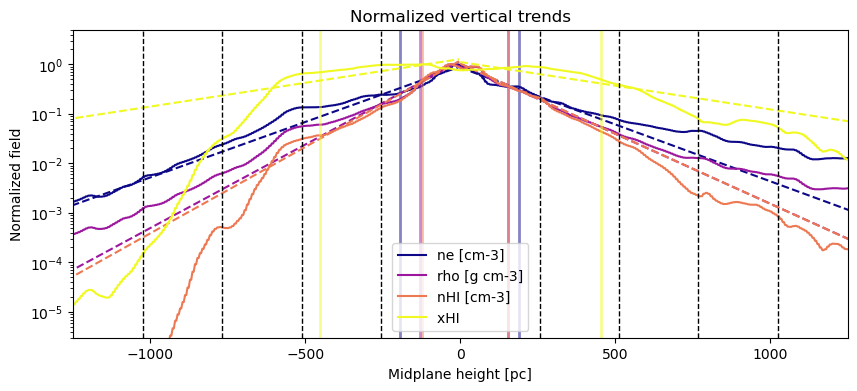

In [5]:
def exp_func_left(x, A, tau):
    return A * np.exp(x / tau)
def exp_func_right(x, A, tau):
    return A * np.exp(-x / tau)

cell_size_pc = 4.0
mid_index = 768
z_indices = np.arange(1536)
z_pc = (z_indices - mid_index) * cell_size_pc

fields_to_plot = ['ne', 'rho', 'nHI', 'xHI']
colors = plt.cm.plasma(np.linspace(0, 1, len(fields_to_plot)))
arrays_to_plot = [electron_density, gas_density, HI_num_density, hydrogen_fraction]
units_to_plot = ['[cm-3]', '[g cm-3]', '[cm-3]', ' ']

plt.figure(figsize=(10, 4), dpi=100)

for field_array, field_name, color, unit_plt in zip(arrays_to_plot, fields_to_plot, colors, units_to_plot):
    mean_profile = np.mean(field_array[field_name].data, axis=(1, 2))
    mean_profile /= np.max(mean_profile)
    
    left_mask = z_pc < 0
    right_mask = z_pc >= 0

    z_left = -z_pc[left_mask]
    z_right = z_pc[right_mask]

    y_left = mean_profile[left_mask]
    y_right = mean_profile[right_mask]

    popt_left, _ = curve_fit(exp_func_left, z_left, y_left, p0=(1, -100))
    popt_right, _ = curve_fit(exp_func_right, z_right, y_right, p0=(1, 100))

    fit_left = exp_func_left(z_left, *popt_left)
    fit_right = exp_func_right(z_right, *popt_right)
    plt.plot(z_pc, mean_profile, label= str(field_name) + ' ' + str(unit_plt), color=color)
    plt.plot(-z_left, fit_left, '--', color=color)
    plt.plot(z_right, fit_right, '--', color=color)

    plt.axvline(x=popt_left[1], color=color, linewidth=2, alpha=0.5)
    plt.axvline(x=popt_right[1], color=color, linewidth=2, alpha=0.5)
    
    print(str(field_name) + ' Tau left: ' + str(abs(popt_left[1])) + ' pc, Tau right: ' + str(popt_right[1]) + ' pc')

#lol = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)).reshape(256, 256, 1536) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)).reshape(256, 256, 1536) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)).reshape(256, 256, 1536))**2 * number_density_cf * 4. * 1e6)
#meow = np.mean(lol, axis=(0,1)).transpose() / (np.mean(gas_density['rho'].data, axis=(1, 2)) * 0.01)
#plt.plot(z_pc, meow / np.max(meow), color='green', label = 'Ha / rho ratio')

for line_pos in [-256, -512, -768, -1024, 256, 512, 768, 1024]:
        plt.axvline(x=line_pos, color='black', linestyle='--', linewidth=1)

plt.xlabel('Midplane height [pc]')
plt.ylabel('Normalized field')
plt.title('Normalized vertical trends')
plt.yscale('log')
plt.xlim(-1250,1250)
plt.ylim(3e-6,5e0)
plt.legend()
plt.savefig(f"{gallery_dir}TIGRESS_exp_disk_cuts.jpeg", format='jpeg', dpi=100)
plt.show()

Ha [erg s-1 kpc-2] Tau left 1: 45.12303811930813 pc, Tau right 1: 36.86093672938986 pc
Ha [erg s-1 kpc-2] Tau left 2: 45.36600852102856 pc, Tau right 2: 244.07236632974457 pc
Dust [g cm-2] Tau left: 128.707380734729 pc, Tau right: 153.66002405859635 pc


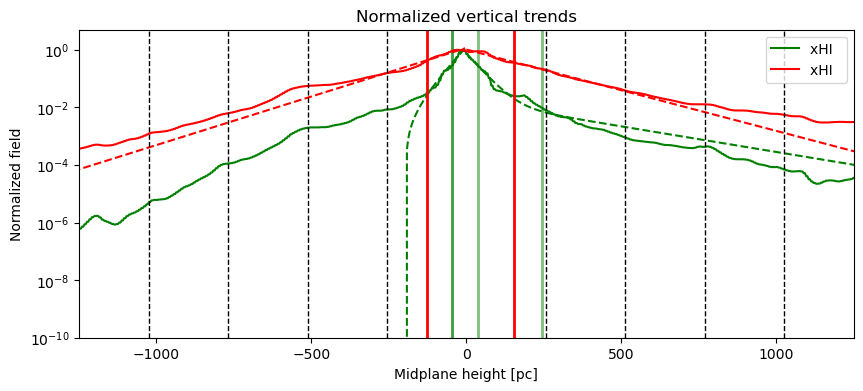

In [62]:
def double_exp_left(z, A1, tau1, A2, tau2):
    return A1 * np.exp(z/tau1) + A2 * np.exp(z/tau2)
def double_exp_right(z, A1, tau1, A2, tau2):
    return A1 * np.exp(-z/tau1) + A2 * np.exp(-z/tau2)

def double_exp_right(z, A1, tau1, A2, tau2):
    return A1 * np.exp(-z/tau1) + A2 * np.exp(-z/tau2)
def double_exp_right(z, A1, tau1, A2, tau2):
    return A1 * np.exp(-z/tau1) + A2 * np.exp(-z/tau2)

Ha_raw = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)).reshape(256, 256, 1536) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)).reshape(256, 256, 1536) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)).reshape(256, 256, 1536))**2 * number_density_cf * 4. * 1e6)
Ha_sb = np.mean(np.sum(Ha_raw, axis=0),axis=0).transpose()

Dust_raw = (gas_density['rho'].data).transpose(2, 1, 0) * dust_to_gas_ratio
Dust_sb = np.mean(np.mean(Dust_raw, axis=0),axis=0).transpose()

def plot_profile_fit_exp(mean_profile, color,name):
    mean_profile /= np.max(mean_profile)

    y_left = mean_profile[left_mask]
    y_right = mean_profile[right_mask]

    popt_left, _ = curve_fit(exp_func_left, z_left, y_left, p0=(1, -100))
    popt_right, _ = curve_fit(exp_func_right, z_right, y_right, p0=(1, 100))

    fit_left = exp_func_left(z_left, *popt_left)
    fit_right = exp_func_right(z_right, *popt_right)
    plt.plot(z_pc, mean_profile, label= str(field_name) + ' ' + str(unit_plt), color=color)
    plt.plot(-z_left, fit_left, '--', color=color)
    plt.plot(z_right, fit_right, '--', color=color)

    plt.axvline(x=popt_left[1], color=color, linewidth=2, alpha=0.5)
    plt.axvline(x=popt_right[1], color=color, linewidth=2, alpha=0.5)

    print(str(name) + ' Tau left: ' + str(abs(popt_left[1])) + ' pc, Tau right: ' + str(popt_right[1]) + ' pc')

def plot_profile_fit_double_exp(mean_profile, color,name):
    mean_profile /= np.max(mean_profile)

    y_left = mean_profile[left_mask]
    y_right = mean_profile[right_mask]

    popt_left, _ = curve_fit(double_exp_left, z_left, y_left, p0=(1, -35, 1.5, -250))
    popt_right, _ = curve_fit(double_exp_right, z_right, y_right, p0=(1, 35, 1.5, 250))

    fit_left = double_exp_left(z_left, *popt_left)
    fit_right = double_exp_right(z_right, *popt_right)
    plt.plot(z_pc, mean_profile, label= str(field_name) + ' ' + str(unit_plt), color=color)
    plt.plot(-z_left, fit_left, '--', color=color)
    plt.plot(z_right, fit_right, '--', color=color)

    plt.axvline(x=popt_left[1], color=color, linewidth=2, alpha=0.5)
    plt.axvline(x=popt_right[1], color=color, linewidth=2, alpha=0.5)

    plt.axvline(x=popt_left[3], color=color, linewidth=2, alpha=0.5)
    plt.axvline(x=popt_right[3], color=color, linewidth=2, alpha=0.5)

    print(str(name) + ' Tau left 1: ' + str(abs(popt_left[1])) + ' pc, Tau right 1: ' + str(popt_right[1]) + ' pc')
    print(str(name) + ' Tau left 2: ' + str(abs(popt_left[3])) + ' pc, Tau right 2: ' + str(popt_right[3]) + ' pc')




plt.figure(figsize=(10, 4), dpi=100)
plot_profile_fit_double_exp(Ha_sb, 'green','Ha [erg s-1 kpc-2]')
plot_profile_fit(Dust_sb, 'red','Dust [g cm-2]')

for line_pos in [-256, -512, -768, -1024, 256, 512, 768, 1024]:
        plt.axvline(x=line_pos, color='black', linestyle='--', linewidth=1)

plt.xlim(-1250,1250)
plt.ylim(1e-10,5e0)
plt.yscale('log')
plt.legend()
plt.xlabel('Midplane height [pc]')
plt.ylabel('Normalized field')
plt.title('Normalized vertical trends')
plt.show()


/tmp/ipykernel_1187587/1949666097.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


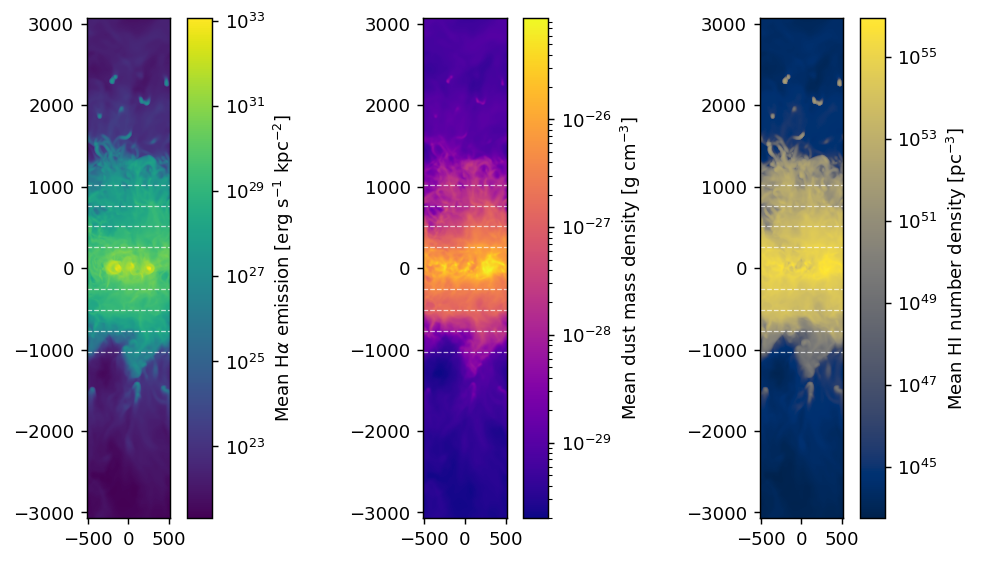

In [5]:
plot_data1 = np.mean((electron_density['ne'].data).transpose(2, 1, 0), axis=1).transpose()
plot_data2 = np.mean((temperature['T'].data).transpose(2, 1, 0), axis=1).transpose()
plot_data3 = np.mean((HI_num_density['nHI'].data).transpose(2, 1, 0), axis=1).transpose() * number_density_cf

plot_data_4 = h_alpha_energy * (1.17e-13 / (4*np.pi)) * ((temperature['T'].data / 1e4)**(-0.942-0.030*np.log(temperature['T'].data / 1e4))) * ((electron_density['ne'].data)**2  * number_density_cf * 4. * 1e6)
plot_data_4 = np.mean(plot_data_4.transpose(2, 1, 0), axis=1).transpose()

plt_data_5 = np.mean((gas_density['rho'].data).transpose(2, 1, 0), axis=1).transpose() * dust_to_gas_ratio
 
nx, ny = plot_data1.shape
x = np.linspace(-nx//2 * 4., nx//2 * 4., nx)
y = np.linspace(-ny//2 * 4., ny//2 * 4., ny)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), dpi=130, gridspec_kw={'wspace': 0.005})

im1 = axes[0].imshow(plot_data_4, cmap='viridis', origin='lower', norm=LogNorm(), extent=[y.min(), y.max(), x.min(), x.max()])
fig.colorbar(im1, ax=axes[0], label=r'Mean H$\alpha$ emission [erg s$^{-1}$ kpc$^{-2}$]', pad=0.05)

im2 = axes[1].imshow(plt_data_5, cmap='plasma', origin='lower', norm=LogNorm(), extent=[y.min(), y.max(), x.min(), x.max()])
fig.colorbar(im2, ax=axes[1], label=r'Mean dust mass density [g cm$^{-3}$]', pad=0.05)

im3 = axes[2].imshow(plot_data3, cmap='cividis', origin='lower', norm=LogNorm(), extent=[y.min(), y.max(), x.min(), x.max()])
fig.colorbar(im3, ax=axes[2], label=r'Mean HI number density [pc$^{-3}$]', pad=0.05)

for ax in axes:
    for pos in [-1024, -768, -512, -256, 256, 512, 768, 1024]:
        ax.axhline(y=pos, color='white', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.savefig(f"{gallery_dir}TIGRESS_longitudinal.jpeg", format='jpeg', dpi=100)
plt.show()

# Taking a slice of the snapshot and checking Ha Surface Brightness

In [7]:
# RIDOTTO: we only take a thin slice of 256 pc
# For the first implementation of the full code, in order to test it as a whole, I only consider a slice of 256 pc
# centered on the galactic plane. With this we'll miss a big part of the less dense gas outside, but I will later modify it to import the full snapshot.
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

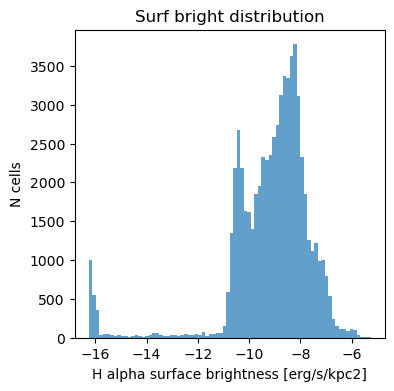

1.87501280651959e-08


In [6]:
# To compute the Halpha luminosity, I used the formula (14.5) by Bruce Draine (2011), page 141.

# To have a first preliminary comparison with PHANGS, the Surface Brightness Distribution of Halpha is in agreement with the one shown in Fig.2
# of Belfiore et. al. (2021) "A tale of two DIGs". The distibuiton is compatible with the faintest ones by the Diffuse Ionized Gas.

fig, ax = plt.subplots(figsize=(4, 4))
raw = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128))**2 * number_density_cf * 4. * 1e6)

omega_sr = (1024 * 1024) / (1e7)**2
arcsec2_over_sr = 4.254791e10
raw_mod = raw * (units.kpc**-2).to(units.cm**-2)
raw_mod = raw_mod / (omega_sr * arcsec2_over_sr)

plot_data = np.sum(raw_mod, axis=-1).transpose()
plt.hist(np.log10(plot_data.flatten()), bins=80, alpha=0.7)
plt.title('Surf bright distribution')
plt.ylabel('N cells')
plt.xlabel('H alpha surface brightness [erg/s/kpc2]')
plt.show()

print(np.mean(plot_data.flatten()))

Unit: W/m2/arcsec2

1.5646682761867884e-20 W/m2/arcsec2
1.5646682761867883e-17 erg/s/cm2/arcsec2
5.981938881977507e+29 erg/s/kpc2


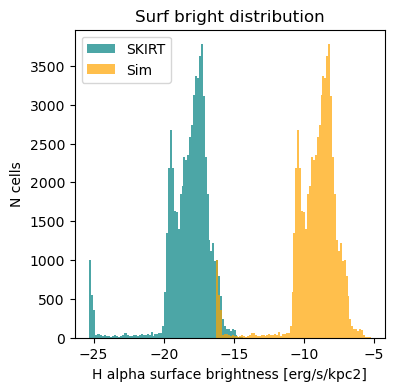

In [50]:

with fits.open("/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/Ha_prova_i0_total.fits") as hdul:
    image_Halpha_W_m2_arcsec2 = hdul[0].data.astype(np.float64)
    image_Halpha_ergs_cm2_arcsec2 = image_Halpha_W_m2_arcsec2 * 1e3
    omega_sr = (3072 * 3072) / (1e7)**2
    arcsec2_over_sr = 4.254791e10
    kpc2_over_cm2 = 1.05027e-43
    image_Halpha_ergs_kpc2 = image_Halpha_ergs_cm2_arcsec2 * omega_sr * arcsec2_over_sr / kpc2_over_cm2
    header = hdul[0].header
    print('Unit: ' + str(header['BUNIT']))
    print()
    print(str(np.mean(image_Halpha_W_m2_arcsec2)) + ' W/m2/arcsec2')
    print(str(np.mean(image_Halpha_ergs_cm2_arcsec2)) + ' erg/s/cm2/arcsec2')
    print(str(np.mean(image_Halpha_ergs_kpc2)) + ' erg/s/kpc2')

fig, ax = plt.subplots(figsize=(4, 4))
plot_data_SKIRT = image_Halpha_ergs_cm2_arcsec2.flatten()
plt.hist(np.log10(plot_data_SKIRT), bins=80, alpha=0.7, color='teal', label='SKIRT')
plt.hist(np.log10(plot_data.flatten()), bins=80, alpha=0.7, color='orange', label='Sim')
plt.title('Surf bright distribution')
plt.ylabel('N cells')
plt.xlabel('H alpha surface brightness [erg/s/kpc2]')
plt.legend()
plt.show()

# Including Shear-Periodic BC

In [4]:
# Expanding the cells borders
Nx_exp = np.array([5 * Nx[0], 5 * Nx[1], Nx[2]])
origin = ds.domain['le'] - 5//2 * Nx * dx

xmin_exp = origin[0] + dx[0] * np.arange(Nx_exp[0])
ymin_exp = origin[1] + dx[1] * np.arange(Nx_exp[1])
zmin_exp = zmin
xmax_exp = xmin_exp + dx[0]
ymax_exp = ymin_exp + dx[1]
zmax_exp = zmax

# Borders of the simulation
print('X borders: ' + str(xmin_exp.min()) + ' pc  to  ' + str(xmax_exp.max()))
print('Y borders: ' + str(ymin_exp.min()) + ' pc  to  ' + str(ymax_exp.max()))
print('Z borders: ' + str(zmin_exp.min()) + ' pc  to  ' + str(zmax_exp.max()))
print('Number of cells: ' + str(Nx_exp))

X borders: -2560.0 pc  to  2560.0
Y borders: -2560.0 pc  to  2560.0
Z borders: -3072.0 pc  to  3072.0
Number of cells: [1280 1280 1536]


In [5]:
# Expanding the extracted fields with the built-in function in Pyathena
electron_density_exp = expand_xy(s,electron_density)
temperature_exp = expand_xy(s,temperature)
gas_density_exp = expand_xy(s,gas_density)
HI_num_density_exp = expand_xy(s,HI_num_density)
#H2_num_density_exp = expand_xy(s,H2_num_density)
hydrogen_fraction_exp = expand_xy(s,hydrogen_fraction)

KeyboardInterrupt: 

In [27]:
def expand_x_5x(sim, data):
    import numpy as np
    import xarray as xr
    from scipy.ndimage import shift

    ds = sim.ds

    try:
        shear = sim.par["configure"]["ShearingBox"] == "yes"
    except KeyError:
        shear = False

    Lx, Ly, Lz = ds.domain["Lx"]
    dx, dy, dz = ds.domain["dx"]

    shifts_x = [-2, -1, 1, 2]
    data_shifted = []

    if shear:
        qshear = sim.par["problem"]["qshear"]
        Omega = sim.par["problem"]["Omega"]
        qOmL = qshear * Omega * Lx
        time = ds.domain["time"]
        qOmLt = qOmL * time

        dims = data.to_array("variable").dims
        ndims = len(dims) - 1
        try:
            yidx = dims.index("y") - 1
        except ValueError:
            raise ValueError("Input data must have 'y' dimension to apply shear-periodic BCs")

    for n in shifts_x:
        d = data.copy(deep=True).assign_coords(x=data.coords["x"] + n * Lx)

        if shear:
            for var in data:
                shifts = np.zeros(ndims)
                shifts[yidx] = -n * qOmLt / dy
                shifted_array = shift(d[var].data, shifts, mode="grid-wrap", order=1)
                if var == "vy":
                    shifted_array += -n * qOmL
                d[var] = (dims[1:], shifted_array)

        data_shifted.append(d)

    return xr.concat([data_shifted[0], data_shifted[1], data, data_shifted[2], data_shifted[3]], dim="x")

def expand_y_5x(sim, data):
    ds = sim.ds

    _, Ly, _ = ds.domain["Lx"]

    data_bot2 = data.copy(deep=True).assign_coords(y=data.coords["y"] - 2*Ly)
    data_bot1 = data.copy(deep=True).assign_coords(y=data.coords["y"] - Ly)
    data_top1 = data.copy(deep=True).assign_coords(y=data.coords["y"] + Ly)
    data_top2 = data.copy(deep=True).assign_coords(y=data.coords["y"] + 2*Ly)

    return xr.concat([data_bot2, data_bot1, data, data_top1, data_top2], dim="y")

def expand_xy_5x(s, data):
    return expand_y_5x(s, expand_x_5x(s, data))

In [29]:
gas_density_exp3 = expand_xy_5x(s,gas_density)

In [37]:
# Expanding the star particles
L_w = Nx * dx

positions_stars_exp3_unmasked = []
velocities_stars_exp3_unmasked = []
mass_stars_exp3_unmasked = []
age_stars_exp3_unmasked_unmasked = []
smoothing_length_stars_exp3_unmasked = []
metallicities_exp3_unmasked = []

for dx_shift in [-4*L_w[0], -3*L_w[0], -2*L_w[0], -L_w[0], 0., L_w[0], 2*L_w[0], 3*L_w[0], 4*L_w[0]]:
    for dy_shift in [-4*L_w[0], -3*L_w[0], -2*L_w[1], -L_w[1], 0., L_w[1], 2*L_w[1], 3*L_w[1], 4*L_w[0]]:

        shifted_pos = positions_stars.copy()

        if (dx_shift==-L_w[0]):
            shear_shift_y = -qOmLt / dx[0]
        elif (dx_shift==L_w[0]):
            shear_shift_y = +qOmLt / dx[0]
        elif (dx_shift==-2*L_w[0]):
            shear_shift_y = -2*qOmLt / dx[0]
        elif (dx_shift==2*L_w[0]):
            shear_shift_y = +2*qOmLt / dx[0]
        else:
            shear_shift_y = 0.

        total_dy = dy_shift

        shifted_pos = positions_stars.copy()
        shifted_pos[:, 0] += (dx_shift)
        shifted_pos[:, 1] += (total_dy + shear_shift_y)
        
        positions_stars_exp3_unmasked.append(shifted_pos)
        velocities_stars_exp3_unmasked.append(velocities_stars)
        mass_stars_exp3_unmasked.append(mass_stars)
        age_stars_exp3_unmasked_unmasked.append(age_stars)
        smoothing_length_stars_exp3_unmasked.append(smoothing_length_stars)
        metallicities_exp3_unmasked.append(metallicities)

positions_stars_exp3_unmasked = np.array(np.vstack(positions_stars_exp3_unmasked))
velocities_stars_exp3_unmasked = np.array(np.vstack(velocities_stars_exp3_unmasked))
mass_stars_exp3_unmasked = np.array(np.hstack(mass_stars_exp3_unmasked))
age_stars_exp3_unmasked = np.array(np.hstack(age_stars_exp3_unmasked_unmasked))
smoothing_length_stars_exp3_unmasked = np.array(np.hstack(smoothing_length_stars_exp3_unmasked))
metallicities_exp3_unmasked = np.array(np.hstack(metallicities_exp3_unmasked))

mask_inside_box3 = (
    (positions_stars_exp3_unmasked[:, 0] >= -2048) & (positions_stars_exp3_unmasked[:, 0] <= 2048) &
    (positions_stars_exp3_unmasked[:, 1] >= -2048) & (positions_stars_exp3_unmasked[:, 1] <= 2048))

positions_stars_exp3 = positions_stars_exp3_unmasked[mask_inside_box3]
velocities_stars_exp3 = velocities_stars_exp3_unmasked[mask_inside_box3]
mass_stars_exp3 = mass_stars_exp3_unmasked[mask_inside_box3]
age_stars_exp3 = age_stars_exp3_unmasked[mask_inside_box3]
smoothing_length_stars_exp3 = smoothing_length_stars_exp3_unmasked[mask_inside_box3]
metallicities_exp3 = metallicities_exp3_unmasked[mask_inside_box3]

print('Initial star number: ' + str(positions_stars.shape[0]) + '; expected after expansion: ' + str(positions_stars.shape[0] * 9))
print('Pre-mask extended star number: ' + str(positions_stars_exp3_unmasked.shape[0]))
print('Masked extended star number: ' + str(positions_stars_exp3.shape[0]))
print()
print('Initial number of cells: ' + str(Nx[0] * Nx[1] * (832-704)))
print('Expected number of cells: ' + str(Nx[0] * Nx[1] * (832-704) * 9))

Initial star number: 122; expected after expansion: 1098
Pre-mask extended star number: 9882
Masked extended star number: 1919

Initial number of cells: 8388608
Expected number of cells: 75497472


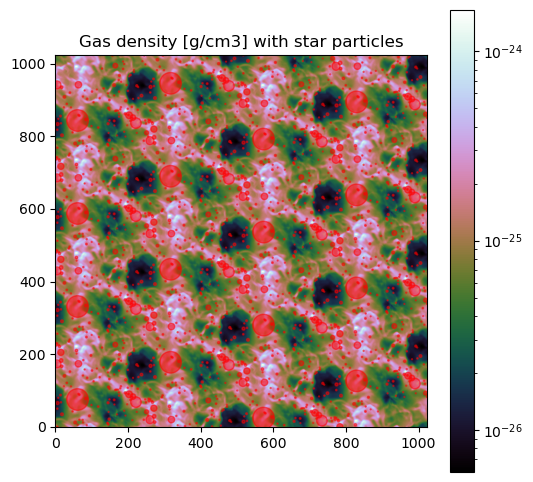

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density_exp3['rho'].data).transpose(2, 1, 0), axis=-1).transpose()[128:1152,128:1152]
plt.scatter(np.array(positions_stars_exp3)[:, 0]/4. + 512., np.array(positions_stars_exp3)[:, 1]/4. + 512., s=(age_stars_exp3 * 1e1 * time_cf)**(-1), c='red', alpha=0.5)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Gas density [g/cm3] with star particles')
plt.show()

# [512:768,512:768]

In [36]:
# Expanding the star particles
L_w = Nx * dx

positions_stars_exp_unmasked = []
velocities_stars_exp_unmasked = []
mass_stars_exp_unmasked = []
age_stars_exp_unmasked_unmasked = []
smoothing_length_stars_exp_unmasked = []
metallicities_exp_unmasked = []

for dx_shift in [-3*L_w[0], -2*L_w[0], -L_w[0], 0., L_w[0], 2*L_w[0], 3*L_w[0]]:
    for dy_shift in [-3*L_w[0], -2*L_w[1], -L_w[1], 0., L_w[1], 2*L_w[1], 3*L_w[1]]:

        shifted_pos = positions_stars.copy()

        if (dx_shift==-L_w[0]):
            shear_shift_y = -qOmLt / dx[0]
        elif (dx_shift==L_w[0]):
            shear_shift_y = +qOmLt / dx[0]
        else:
            shear_shift_y = 0.

        total_dy = dy_shift

        shifted_pos = positions_stars.copy()
        shifted_pos[:, 0] += (dx_shift)
        shifted_pos[:, 1] += (total_dy + shear_shift_y)
        
        positions_stars_exp_unmasked.append(shifted_pos)
        velocities_stars_exp_unmasked.append(velocities_stars)
        mass_stars_exp_unmasked.append(mass_stars)
        age_stars_exp_unmasked_unmasked.append(age_stars)
        smoothing_length_stars_exp_unmasked.append(smoothing_length_stars)
        metallicities_exp_unmasked.append(metallicities)

positions_stars_exp_unmasked = np.array(np.vstack(positions_stars_exp_unmasked))
velocities_stars_exp_unmasked = np.array(np.vstack(velocities_stars_exp_unmasked))
mass_stars_exp_unmasked = np.array(np.hstack(mass_stars_exp_unmasked))
age_stars_exp_unmasked = np.array(np.hstack(age_stars_exp_unmasked_unmasked))
smoothing_length_stars_exp_unmasked = np.array(np.hstack(smoothing_length_stars_exp_unmasked))
metallicities_exp_unmasked = np.array(np.hstack(metallicities_exp_unmasked))

mask_inside_box = (
    (positions_stars_exp_unmasked[:, 0] >= -1536) & (positions_stars_exp_unmasked[:, 0] <= 1536) &
    (positions_stars_exp_unmasked[:, 1] >= -1536) & (positions_stars_exp_unmasked[:, 1] <= 1536))

positions_stars_exp = positions_stars_exp_unmasked[mask_inside_box]
velocities_stars_exp = velocities_stars_exp_unmasked[mask_inside_box]
mass_stars_exp = mass_stars_exp_unmasked[mask_inside_box]
age_stars_exp = age_stars_exp_unmasked[mask_inside_box]
smoothing_length_stars_exp = smoothing_length_stars_exp_unmasked[mask_inside_box]
metallicities_exp = metallicities_exp_unmasked[mask_inside_box]

print('Initial star number: ' + str(positions_stars.shape[0]) + '; expected after expansion: ' + str(positions_stars.shape[0] * 9))
print('Pre-mask extended star number: ' + str(positions_stars_exp_unmasked.shape[0]))
print('Masked extended star number: ' + str(positions_stars_exp.shape[0]))
print()
print('Initial number of cells: ' + str(Nx[0] * Nx[1] * (832-704)))
print('Expected number of cells: ' + str(Nx[0] * Nx[1] * (832-704) * 9))

Initial star number: 122; expected after expansion: 1098
Pre-mask extended star number: 5978
Masked extended star number: 1098

Initial number of cells: 8388608
Expected number of cells: 75497472


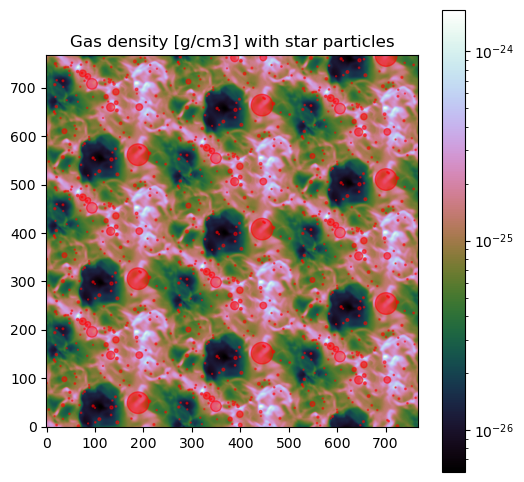

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density_exp['rho'].data).transpose(2, 1, 0), axis=-1).transpose()
plt.scatter(np.array(positions_stars_exp)[:, 0]/4. + 384., np.array(positions_stars_exp)[:, 1]/4. + 384., s=(age_stars_exp * 1e1 * time_cf)**(-1), c='red', alpha=0.5)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Gas density [g/cm3] with star particles')
plt.show()

# [256:512,256:512]

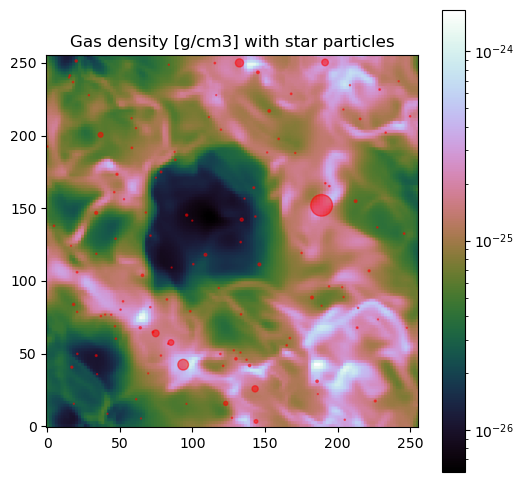

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density['rho'].data).transpose(2, 1, 0), axis=-1).transpose()
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=(age_stars * 1e1 * time_cf)**(-1), c='red', alpha=0.5)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Gas density [g/cm3] with star particles')
plt.show()

# Creating arrays to export

In [15]:
# I computed the 21cm luminosity with a first-order approximation by employing the formula (8.3)
# by Bruce Draine (2011), page 71.
print('The pre-factor is: ' + str((3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2))

def mean_density_star_disk(xmin, ymin, zmin, xmax, ymax, zmax):
    sigma_star=42
    z_star=245

    def rho_z(z):
        return (sigma_star / 2) * (z_star**2) / ( (z**2 + z_star**2)**(3/2) )
        
    integral_rho, _ = quad(rho_z, zmin, zmax)
    mean_density = (integral_rho * dx[0] * dx[1]) / volume

    # the result is in Msun/pc**3
    return mean_density

The pre-factor is: 2.0457927857142857e-32


In [14]:
# I arrange the data in several arrays: the spatial indexed distribution of the gas (Halfa_array) and its Halpha emission (SED_array); 
# the dust distribution (dust_array) for which I considered a solar neighbourhood D/G ratio; the hydrogen distribution (hydrogen_array)
# and its 21cm emission (HI_emission_array).
# The next step will be to import the velocities of the gas cells.

# Since SKIRT samples photons from SEDs, I had to index the cells and the luminosities.

Halfa_array = []
SED_array = []

old_disk_array = []

dust_array = []

hydrogen_array = []
HI_emission_array = []

ID_number = 0

# Too change from normal to S-PBC expanded add:
# _exp
# Nx_exp instead of Nx

for i in range(Nx_exp[0]):
    print(i)
    for j in range(Nx_exp[1]):
        for k in range(704, 832):
            xmin_val = xmin_exp[i]
            ymin_val = ymin_exp[j]
            zmin_val = zmin_exp[k]
            xmax_val = xmax_exp[i]
            ymax_val = ymax_exp[j]
            zmax_val = zmax_exp[k]
            
            dust_density_val = (gas_density_exp['rho'].data)[k, j, i].astype(np.float64) * dust_to_gas_ratio
            temperature_val = (temperature_exp['T'].data)[k, j, i].astype(np.float64)
            HI_ndens_val = (HI_num_density_exp['nHI'].data)[k, j, i].astype(np.float64)
            #H2_ndens_val = (H2_num_density_exp['nH2'].data)[k, j, i].astype(np.float64)
            metallicities_val = solar_metallicity * 0.03

            ne2 = (electron_density_exp['ne'].data)[k, j, i].astype(np.float64)
            T_4 = (temperature_exp['T'].data)[k, j, i].astype(np.float64) / 1e4
            h_alpha_luminosity_val = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (T_4**(-0.942-0.030*np.log(T_4))) * (ne2**2 * number_density_cf * volume)
            
            hydrogen_density_val = (HI_ndens_val) * H_mass_grams
            H_surf_val = hydrogen_density_val * (units.g).to(units.M_sun) * number_density_cf * 4.0

            HI_prefattore = (3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2
            HI_lum_val = HI_prefattore * HI_ndens_val * number_density_cf * volume

            star_disk_mass_val = mean_density_star_disk(xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val) * volume

            Halfa_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, ID_number, dust_density_val])
            SED_array.append([h_alpha_wave, h_alpha_luminosity_val, ID_number])
            dust_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, dust_density_val, temperature_val])          
            hydrogen_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, hydrogen_density_val, metallicities_val, temperature_val, H_surf_val])
            HI_emission_array.append([HI_lum_val])
            old_disk_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, star_disk_mass_val, solar_metallicity, 9.99])

            ID_number = ID_number + 1

print("Final ID_Number: " + str(ID_number))
del ID_number

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Making them numpy array (suspended for type)

Halfa_array = np.array(Halfa_array)
SED_array = np.array(SED_array)
dust_array = np.array(dust_array)
hydrogen_array = np.array(hydrogen_array)
HI_emission_array = np.array(HI_emission_array)
old_disk_array = np.array(old_disk_array)

In [15]:
# Checking indexes
print('ID numbers cells: ' + str(Halfa_array[:,6]))
print('ID numbers luminosities: ' + str(SED_array[:,2]))

TypeError: list indices must be integers or slices, not tuple

In [25]:
# Checking old stars disk 
print('Total mass analitically computed: ' + str(9 * 1024 * 1024 * 42 * 256 / np.sqrt(256**2 + 245**2)) + ' Msun')
print('Total mass computed as mean density * volume * number cells: ' + str(np.mean(old_disk_array[:,6]) * 75497472) + ' Msun')
print('Difference An - Num: ' + str((9 * 1024 * 1024 * 42 * 256 / np.sqrt(256**2 + 245**2)) - (np.mean(old_disk_array[:,6]) * 75497472)) + ' Msun')
print('Average metallicity: ' + str(np.mean(old_disk_array[:,7])))

Total mass analitically computed: 286354686.6921231 Msun
Total mass computed as mean density * volume * number cells: 286354686.6921526 Msun
Difference An - Num: -2.950429916381836e-05 Msun
Average metallicity: 0.01340000000000148


# Sanity check & HI maps

NameError: name 'SED_array' is not defined

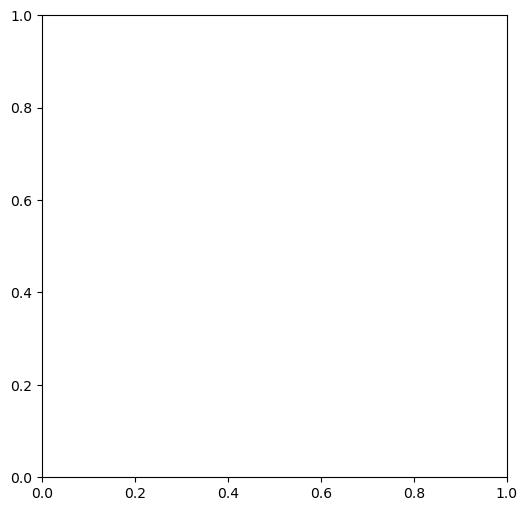

In [18]:
# I plot the surface brightness distribution of the Halpha

fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(SED_array[:,1].reshape(768, 768, 128), axis=-1).transpose()
plot_data = plot_data / (4. * 4. * 1e-6)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('H alpha surface brightness [erg/s/kpc2]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )
print('Actual range ' + str(37) + ' to ' + str(41) )

In [27]:
# Since the averages of some physical quantities are needed for SKIRT, I print them

print('Default metallicity of the gas: ' + str(np.mean(hydrogen_array[:,7])))
print('Average temperature of the gas: ' + str(np.mean(hydrogen_array[:,8])) + ' K')
print('Average Sur Mass Dens of the gas: ' + str(np.mean(hydrogen_array[:,9])) + ' Msun/pc3')

# In order to convert from/to (erg/s) to/from (MJy/sr) I create this conversion factor
prefattore = 1e23 * 1e8 * 1e-6 / (4*np.pi* (3.086e25)**2) # (erg/s) -> (MJy/sr) conversion
print('The conversion factor from (erg/s) to (MJy/sr) (prefattore) is ' + str(prefattore) + ' MJy * s/erg * sr')

Default metallicity of the gas: 0.00040199999999991084
Average temperature of the gas: 499558.7957781564 K
Average Sur Mass Dens of the gas: 0.03778798816807545 Msun/pc3
The conversion factor from (erg/s) to (MJy/sr) (prefattore) is 8.355997329728561e-28 MJy * s/erg * sr


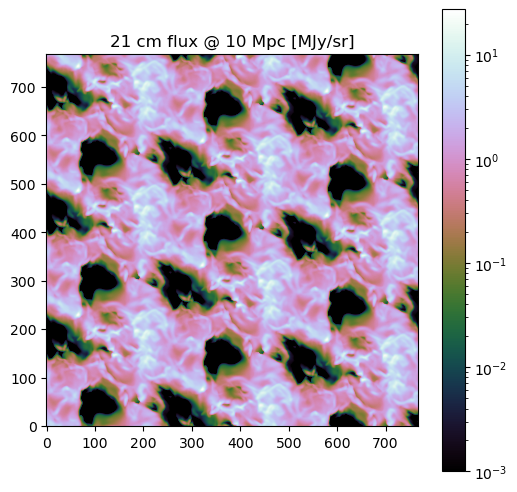

Dynamical range -10.897604187515192 to 1.4384171273116286


In [35]:
# I plot the flux of the 21 cm (for a distance of 10 Mpc).
# Since the photodissociation of H2 is already simulated in TIGRESS ISM, I do not need to process the HI map through SKIRT

fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(HI_emission_array.reshape(768, 768, 128), axis=-1).transpose()
plot_data = plot_data * prefattore
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e-3, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('21 cm flux @ 10 Mpc [MJy/sr]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )

In [120]:
# The second preliminary comparison with PHANGS is for the 21 cm line emission, rather than for the Halpha.
# I wanted to compare the surface mass density of the snapshot slice with the ones in Eibensteiner et al. (2024)
# "PHANGS-MeerKAT and MHONGOOSE HI observations".
# I recall that SKIRT takes as input the surface mass density of HI + H2, so I expect my results to be an overestimate.
# The distances in the plot will of course not be galactocentric, but from the center of the snapshot, so are just meant
# to distinguish the cells. Nevertheless, the snapshot is simulated in the solar neighbourhood, so I expect
# it to be compatible with the first 5-8 kpc of the plots in Eibensteiner et al. (2024).

gal_distance = 1e-3 * np.sqrt( ((hydrogen_array[:,0] + hydrogen_array[:,3]) / 2)**2 + ((hydrogen_array[:,1] + hydrogen_array[:,4]) / 2)**2 )
gal_distance = gal_distance.reshape(768, 768, 128)[...,0].transpose()
gas_surf = np.sum(hydrogen_array[:,9].reshape(768, 768, 128), axis=-1).transpose()

plt.figure(figsize=(5, 3))
plt.scatter(gal_distance, gas_surf, c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 4pc)')
plt.show()

KeyboardInterrupt: 

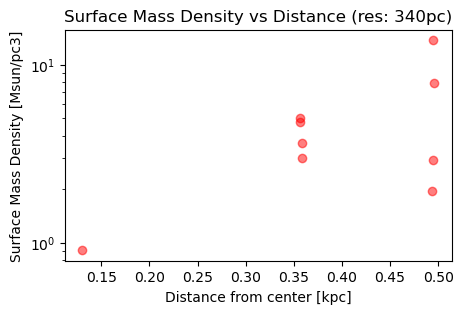

In [13]:
# The large drop on the left side of the plot is given by the big void in the center of the snapshot. In the TIGRESS
# ISM simulation, the cells have a spacial resolution of 4 pc, thus I need to rebin the plot so to sample it with a
# realistic resolution. Since the face-on snapshot is 1024x1024pc, I cannot sample it with coarser resolutions: in Table 2
# of Eibensteiner et al. (2024) the observation of NGC 5068 is indicated to have a beam size of 0.34 kpc, so I choose that
# as a possible observational resolution (leading to a 3x3 pixel rebinned plot). 
# The resulting Surface Mass Density of HI + H2 is compatible with Panel 4 of Figure 7 of Eibensteiner et al. (2024).
# However, the images and plots of the paper are all made so to have a resolution around 15", that is 1500pc circa.

def process_arrays(distan, densit, macro_size=(85, 85, 86)):
    result_dist = np.zeros((3, 3))
    result_dens = np.zeros((3, 3))
    
    for i in range(3):
        for j in range(3):
            row_start = i * macro_size[i] if i < 2 else (i * macro_size[i])
            row_end = (i + 1) * macro_size[i] if i < 2 else 256
            col_start = j * macro_size[j] if j < 2 else (j * macro_size[j])
            col_end = (j + 1) * macro_size[j] if j < 2 else 256

            result_dist[i, j] = np.mean(distan[row_start:row_end, col_start:col_end])
            result_dens[i, j] = np.mean(densit[row_start:row_end, col_start:col_end])
    
    return result_dist, result_dens

plt.figure(figsize=(5, 3))
plt.scatter(process_arrays(gal_distance, gas_surf)[0], process_arrays(gal_distance, gas_surf)[1], c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 340pc)')
plt.show()

# Putting the stars in an array

In [27]:
counter = 0
for i in np.arange(positions_stars_exp.shape[0]):
        if (704 * 4 - 3072 <= positions_stars_exp[i,2]):
            if (positions_stars_exp[i,2] < 832 * 4 - 3072):
                counter = counter + 1
print(str(counter) + ' stars in the area VS total of ' + str(positions_stars_exp.shape[0]))

1089 stars in the area VS total of 1098


In [29]:
stars_array_exp = []
for i in np.arange(positions_stars_exp.shape[0]):
    if (704 * 4 - 3072 <= positions_stars_exp[i,2]):
        if (positions_stars_exp[i,2] < 832 * 4 - 3072):
            position_x = positions_stars_exp[i,0]
            position_y = positions_stars_exp[i,1]
            position_z = positions_stars_exp[i,2]
            smoothing_length = smoothing_length_stars_exp[i]
            
            #velocity_x = velocities_stars_exp[i,0]
            #velocity_y = velocities_stars_exp[i,1]
            #velocity_z = velocities_stars_exp[i,2]
            
            mass = mass_stars_exp[i] * mass_cf * 1.5 # SKIRT wants the initial mass, not the current mass, so I add +50%
            metal = metallicities_exp[i]
            age = age_stars_exp[i] * time_cf

            stars_array_exp.append([position_x, position_y, position_z, smoothing_length, mass, metal, age])
stars_array_exp = np.array(stars_array_exp)
print(stars_array_exp.shape)

(1089, 7)


# Transforming the Stars Particles in Cell Sources (Optional)

In [88]:
#ix = np.searchsorted(xmax_exp, stars_array_exp[:, 0])
#iy = np.searchsorted(ymax_exp, stars_array_exp[:, 1])
#iz = np.searchsorted(zmax_exp, stars_array_exp[:, 2])

ix = np.searchsorted(xmin_exp, stars_array_exp[:, 0], side='right') - 1
iy = np.searchsorted(ymin_exp, stars_array_exp[:, 1], side='right') - 1
iz = np.searchsorted(zmin_exp, stars_array_exp[:, 2], side='right') - 1

cell_index = ix * ymin_exp.shape[0] * zmin_exp.shape[0] + iy * zmin_exp.shape[0] + iz

cell_xmin = xmin_exp[ix]
cell_xmax = xmax_exp[ix]
cell_ymin = ymin_exp[iy]
cell_ymax = ymax_exp[iy]
cell_zmin = zmin_exp[iz]
cell_zmax = zmax_exp[iz]

stars_array_cells_exp = np.stack([cell_xmin, cell_ymin, cell_zmin, cell_xmax, cell_ymax, cell_zmax, stars_array_exp[:, 4], stars_array_exp[:, 5], stars_array_exp[:, 6]], axis=1)
print('Stars Cells ' + str(stars_array_cells_exp.shape[0]))

duplicates = Counter(cell_index)
duplicates = {k: v for k, v in duplicates.items() if v > 1}

if duplicates:
    print('Found ' + str(len(duplicates)) + ' cells with more than one particle')
    for idx, count in duplicates.items():
        print('Index of the cell ' + str(idx) +  ' with ' + str(count) + ' particles')
else:
    print('All of the cells only have one particle inside')

valid = ((ix >= 0) & (ix < xmin_exp.shape[0]) & (iy >= 0) & (iy < ymin_exp.shape[0]) & (iz >= 703) & (iz < 832))
print('If 0, all cells are inside the box borders: ' + str(np.count_nonzero(~valid)))

Stars Cells 1089
All of the cells only have one particle inside
If 0, all cells are inside the box borders: 0


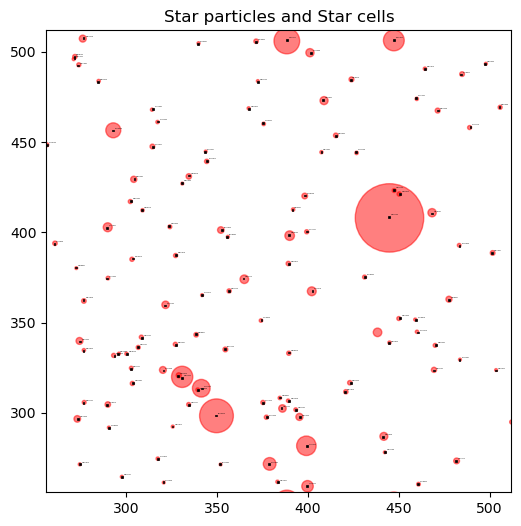

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.array(positions_stars_exp)[:, 0]/4. + 384., np.array(positions_stars_exp)[:, 1]/4. + 384., s=(age_stars_exp * 1e0 * time_cf)**(-1), c='red', alpha=0.5)

for i in range(len(stars_array_cells_exp)):
    xmin = stars_array_cells_exp[i, 0] / 4. + 384.
    xmax = stars_array_cells_exp[i, 3] / 4. + 384.
    ymin = stars_array_cells_exp[i, 1] / 4. + 384.
    ymax = stars_array_cells_exp[i, 4] / 4. + 384.

    width = xmax - xmin
    height = ymax - ymin

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=0.5, edgecolor='black', facecolor='black')
    ax.add_patch(rect)
    ax.text(xmax + 0.5, ymax + 0.5, str(cell_index[i]), fontsize=1, color='black', clip_on=True)

ax.set_xlim(256, 512)
ax.set_ylim(256, 512)
ax.set_title('Star particles and Star cells')
plt.show()

# Saving the data

In [26]:
# Now I save the arrays in .txt file (the next step will be to save them as .scol, which is the only other format
# that SKIRT can import sources and medium).

fmt_Halfa = ["%g", "%g", "%g", "%g", "%g", "%g", "%d", "%g"]
header = """# Halfa_Ridotto_exp.txt: import file for cell source -- Halfa
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: index (1)
# Column 8: mass density (g/cm3)
#
"""
with open(f"{output_dir_exp}Halfa_Ridotto_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, Halfa_array, fmt=fmt_Halfa)

#######################################################################################################################

header = """# Dust_Ridotto_exp.txt: import file for cell media -- dust
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: temperature (K)
#
"""
with open(f"{output_dir_exp}Dust_Ridotto_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, dust_array, fmt="%g")

########################################################################################################################

header = """# Hydrogen_21_Ridotto_exp.txt: import file for cell media -- gas
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: metallicity (1)
# Column 9: temperature (K)
# Column 10: surface mass density (Msun/pc2)
#
"""
with open(f"{output_dir_exp}Hydrogen_21_Ridotto_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, hydrogen_array, fmt="%g")

########################################################################################################################

header = """# Hydrogen_21_Ridotto_ConEmissione_exp.txt: import file for cell media -- gas
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: metallicity (1)
# Column 9: temperature (K)
# Column 10: surface mass density (Msun/pc2)
# Column 11: HI luminosity (MJy/sr)
#
"""
with open(f"{output_dir_exp}Hydrogen_21_Ridotto_ConEmissione_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, np.hstack((hydrogen_array, HI_emission_array)), fmt="%g")

########################################################################################################################

header = """# Old_Stars_Ridotto_exp.txt: import file for cell source 
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass (Msun)
# Column 8: metallicity (1)
# Column 9: age (Gyr)
#
"""

with open(f"{output_dir_exp}Old_Stars_Ridotto_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, old_disk_array, fmt="%g")

########################################################################################################################

header = """# Stars_Ridotto_exp.txt: import file for particle source 
# Column 1: position x (pc)
# Column 2: position y (pc)
# Column 3: position z (pc)
# Column 4: smoothing length (pc)
# Column 5: mass (Msun)
# Column 6: metallicity (1)
# Column 7: age (Gyr)
#
"""
with open(f"{output_dir_exp}Stars_Ridotto_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, stars_array_exp, fmt="%g")

########################################################################################################################

header = """# Stars_Ridotto_Cells_exp.txt: import file for cell source 
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass (Msun)
# Column 8: metallicity (1)
# Column 9: age (Gyr)
#
"""

with open(f"{output_dir_exp}Stars_Ridotto_Cells_exp.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, stars_array_cells_exp, fmt="%g")

In [25]:
# The indexed SEDs are saved as .stab as it is the only format that SKIRT likes to import SEDs
# Furthermore, it is needed to convert from erg/s a watt

from pts.storedtable.io import writeStoredTable
def convertMonochromaticSimulation(wavelengths, luminosities, indexes, outFilePath):
    erg_to_watt = 1e-7
    luminosities_per_micron = luminosities * erg_to_watt
    w = np.array([0.656, 0.657])
    print(w)

    ID = indexes
    print(ID.shape)
    print(ID)
    print(np.arange(len(luminosities)))
    
    L = np.zeros((len(w), len(luminosities)))
    L[0, :] = luminosities * 1e3
    L[1, :] = luminosities * 1e3
    print(L.shape)
    print(L)

    writeStoredTable(outFilePath,['lambda', 'index'], ['m', '1'], ['lin', 'lin'],[w*1e-6, ID],['Llambda'], ['W/m'], ['lin'], [L*1e6])
    
convertMonochromaticSimulation(SED_array[:,0], SED_array[:,1], SED_array[:,2].astype(int), f"{output_dir_exp}SEDfamily_Ridotto_exp.stab")

[0.656 0.657]
(75497472,)
[       0        1        2 ... 75497469 75497470 75497471]
[       0        1        2 ... 75497469 75497470 75497471]
(2, 75497472)
[[9.08122061e+30 9.08122061e+30 1.00863022e+31 ... 8.53331749e+32
  6.91559422e+32 6.91559422e+32]
 [9.08122061e+30 9.08122061e+30 1.00863022e+31 ... 8.53331749e+32
  6.91559422e+32 6.91559422e+32]]


In [26]:
from pts.storedtable.io import readStoredTable
readStoredTable(f"{output_dir_exp}SEDfamily_Ridotto_exp.stab")

{'axisNames': ['lambda', 'index'],
 'axisUnits': ['m', '1'],
 'axisScales': ['lin', 'lin'],
 'quantityNames': ['Llambda'],
 'quantityUnits': ['W/m'],
 'quantityScales': ['lin'],
 'lambda': <Quantity [6.56e-07, 6.57e-07] m>,
 'index': <Quantity [0.0000000e+00, 1.0000000e+00, 2.0000000e+00, ..., 7.5497469e+07,
            7.5497470e+07, 7.5497471e+07]>,
 'Llambda': <Quantity [[9.08122061e+36, 9.08122061e+36, 1.00863022e+37, ...,
             8.53331749e+38, 6.91559422e+38, 6.91559422e+38],
            [9.08122061e+36, 9.08122061e+36, 1.00863022e+37, ...,
             8.53331749e+38, 6.91559422e+38, 6.91559422e+38]] W / m>}

In [30]:
# H alpha
# The SKIRT model for the H alpha is called:             HaTr3.ski
# And should be run in the tmux session called:          Dalarna


# 21 micron Dust
# The SKIRT model for the 21 micron Dust is called:      IRTr3.ski
# And should be run in the tmux session called:          Skane

# Halpha map

8.355997329728561e-28


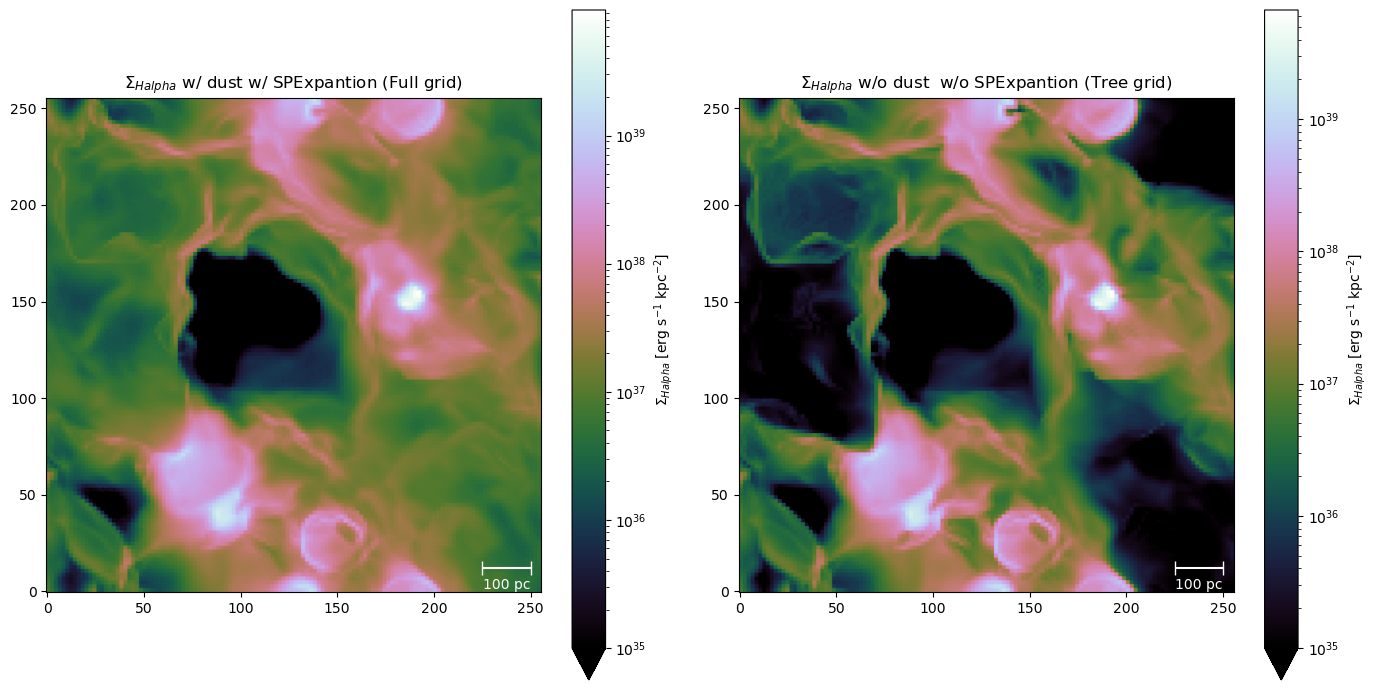

BUNIT with dust: MJy/sr
Range with dust: 6.639577212625888e+32 to 9.543097831816847e+39
BUNIT without dust: MJy/sr
Range without dust: 2.11800860232099e+29 to 6.686841533710144e+39


In [4]:
# Now that I exported all the input files for SKIRT, I write and run the SKIRT codes for the radiative transfer.
# The simulated system was placed at a distance of 10 Mpc from the detector.
# SKIRT returns datacubes measured as MJy/sr, so I had to multiply for the conversionf actor (prefattore) to get the luminosity
# and then divide for the cell surface to get the surface brightness.
# Here I visualize the dust extinction by plotting the Halpha flux with and without the dust, to then plot the extintion.

prefattore = 1e23 * 1e8 * 1e-6 / (4 * np.pi * (3.086e25)**2) # (erg/s) -> (MJy/sr)
print(prefattore)

from astropy.io import fits
with fits.open(f"{output_dir_exp}HaTr3_i0_total.fits") as hdul:
    image_fits = hdul[0].data.astype(np.float64) / prefattore
    image_fits = image_fits / (16e-6)
    header = hdul[0].header
with fits.open(f"{output_dir_exp}HaTr3_i0_primarydirect.fits") as hdul:
    image_fits_nodust = hdul[0].data.astype(np.float64) / prefattore
    image_fits_nodust = image_fits_nodust / (16e-6)
    header_nodust = hdul[0].header

# [100:200,150:250]
# [:,64:192]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
palette = plt.cm.cubehelix.with_extremes(bad='k')
im1 = axes[0].imshow(np.squeeze(image_fits), cmap=palette, origin='lower', norm=LogNorm(vmin=1e35, vmax=image_fits.max()))
#axes[0].set_xticks(np.arange(0, 101, 10))
#axes[0].set_yticks(np.arange(0, 101, 10))
#axes[0].grid(True)
cbar = plt.colorbar(im1, ax=axes[0], extend='min')
cbar.set_label(r'$\Sigma$$_{Halpha}$ [erg s$^{-1}$ kpc$^{-2}$]')
axes[0].set_title(r'$\Sigma$$_{Halpha}$ w/ dust w/ SPExpantion (Full grid)')
trans = transforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].errorbar(237.5, 0.05, xerr=12.5, color='white', capsize=5, transform=trans)
axes[0].text(237.5, 0.03, '100 pc', color='white', ha='center', va='top', transform=trans)

im2 = axes[1].imshow(np.squeeze(image_fits_nodust), cmap=palette, origin='lower', norm=LogNorm(vmin=1e35, vmax=image_fits_nodust.max()))
#axes[1].grid(True)
cbar = plt.colorbar(im2, ax=axes[1], extend='min')
cbar.set_label(r'$\Sigma$$_{Halpha}$ [erg s$^{-1}$ kpc$^{-2}$]')
axes[1].set_title('$\Sigma$$_{Halpha}$ w/o dust  w/o SPExpantion (Tree grid)')
trans = transforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)
axes[1].errorbar(237.5, 0.05, xerr=12.5, color='white', capsize=5, transform=trans)
axes[1].text(237.5, 0.03, '100 pc', color='white', ha='center', va='top', transform=trans)

plt.tight_layout()
plt.show()

print(f"BUNIT with dust: {header['BUNIT']}")
print('Range with dust: ' + str(image_fits.min()) + ' to ' + str(image_fits.max()))
print(f"BUNIT without dust: {header_nodust['BUNIT']}")
print('Range without dust: ' + str(image_fits_nodust.min()) + ' to ' + str(image_fits_nodust.max()))

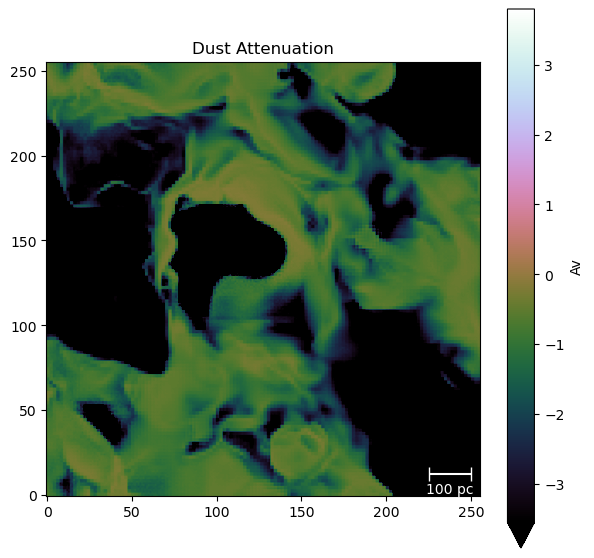

BUNIT: MJy/sr
Range: -9.778596967967529 to -0.163998517790427


In [5]:
# In this picture we can see the attenuation, represented as Av (Av =  -2.5 log(wdust / wodust)).
# This results in the attenutation in the dense regions and the double-scattering onto the line of sight that enhances the fainter regions.

image_fits_atten_nomasked = np.squeeze(image_fits) / np.squeeze(np.where(image_fits_nodust == 0, 0.00005801245, image_fits_nodust))
image_fits_atten = np.ma.masked_where(image_fits_atten_nomasked >= 50, image_fits_atten_nomasked)

image_fits_atten = - 2.5 * np.log(np.squeeze(image_fits_atten))

fig, ax = plt.subplots(figsize=(7, 7))
palette = plt.cm.cubehelix.with_extremes(bad='k')
im = ax.imshow(np.squeeze(image_fits_atten), cmap=palette, origin='lower', vmin=-3.555999, vmax=3.7980096)
cbar = plt.colorbar(im, ax=ax, extend='min')
cbar.set_label(r'Av')
ax.set_title('Dust Attenuation')
#plt.xlim(150,200)
#plt.ylim(130,180)
#plt.grid()
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.errorbar(237.5, 0.05, xerr=12.5, color='white', capsize=5, transform=trans)
ax.text(237.5, 0.03, '100 pc', color='white', ha='center', va='top', transform=trans)

plt.show()

print(f"BUNIT: {header_nodust['BUNIT']}")
print('Range: ' + str(image_fits_atten.min()) + ' to ' + str(image_fits_atten.max()))

# Full SED and 21 $\mu$m maps

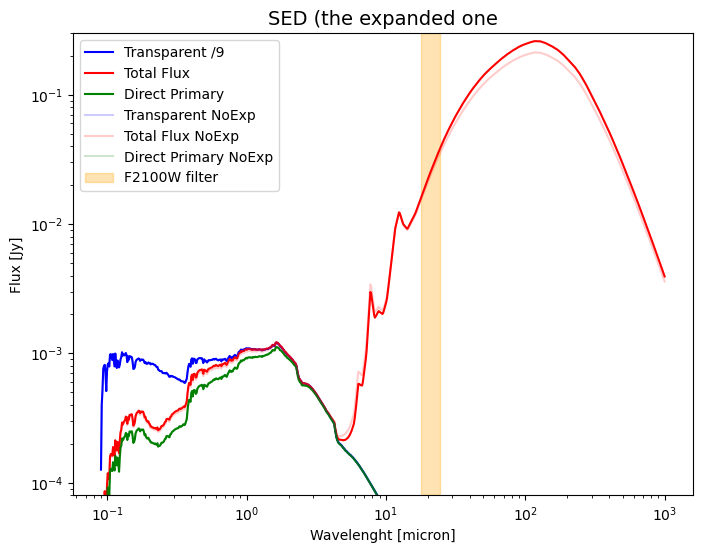

In [8]:
# The two SEDs, expanded and not expanded.
# The former is not gridded in the full frame.

plot_sed_exp = np.loadtxt(f"{output_dir_exp}IRTr3_i0_sed.dat")
plot_sed_noexp = np.loadtxt(f"{output_dir_IR}IRTr2_Disk_SB99_i0_sed.dat")

plt.figure(figsize=(8, 6))

plt.plot(plot_sed_exp[:,0], plot_sed_exp[:,2]/9, color="blue", linewidth=1.5, label='Transparent /9')
plt.plot(plot_sed_exp[:,0], plot_sed_exp[:,1]/9, color="red", linewidth=1.5, label='Total Flux')
plt.plot(plot_sed_exp[:,0], plot_sed_exp[:,3]/9, color="green", linewidth=1.5, label='Direct Primary')

plt.plot(plot_sed_noexp[:,0], plot_sed_noexp[:,2], color="blue", linewidth=1.5, label='Transparent NoExp', alpha=0.2)
plt.plot(plot_sed_noexp[:,0], plot_sed_noexp[:,1], color="red", linewidth=1.5, label='Total Flux NoExp', alpha=0.2)
plt.plot(plot_sed_noexp[:,0], plot_sed_noexp[:,3], color="green", linewidth=1.5, label='Direct Primary NoExp', alpha=0.2)

plt.xlabel("Wavelenght [micron]")
plt.ylabel("Flux [Jy]")
plt.title("SED (SPExpanded and not)", fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.ylim(8e-5,3e-1)
plt.axvspan(17.907784, 24.478051, color='orange', alpha=0.3, label='F2100W filter')
plt.legend()

#plt.savefig(f"{output_dir}IRTr2_i0_SED.jpg", dpi=300, bbox_inches='tight', format='jpg')

plt.show()

In [30]:
def closest_slice(array, number):
    dist = np.abs(array - number)
    indice = np.argmin(dist)
    return indice
print('Exp: ' + str(closest_slice(plot_sed_exp[:,0])) + ' at ' + str(plot_sed_exp[closest_slice(plot_sed_exp[:,0]),1]))
print('NoExp: ' + str(closest_slice(plot_sed_noexp[:,0])) + ' at ' + str(plot_sed_noexp[closest_slice(plot_sed_noexp[:,0]),1]))

Exp: 438 at 0.2277661082
NoExp: 438 at 0.02384798873


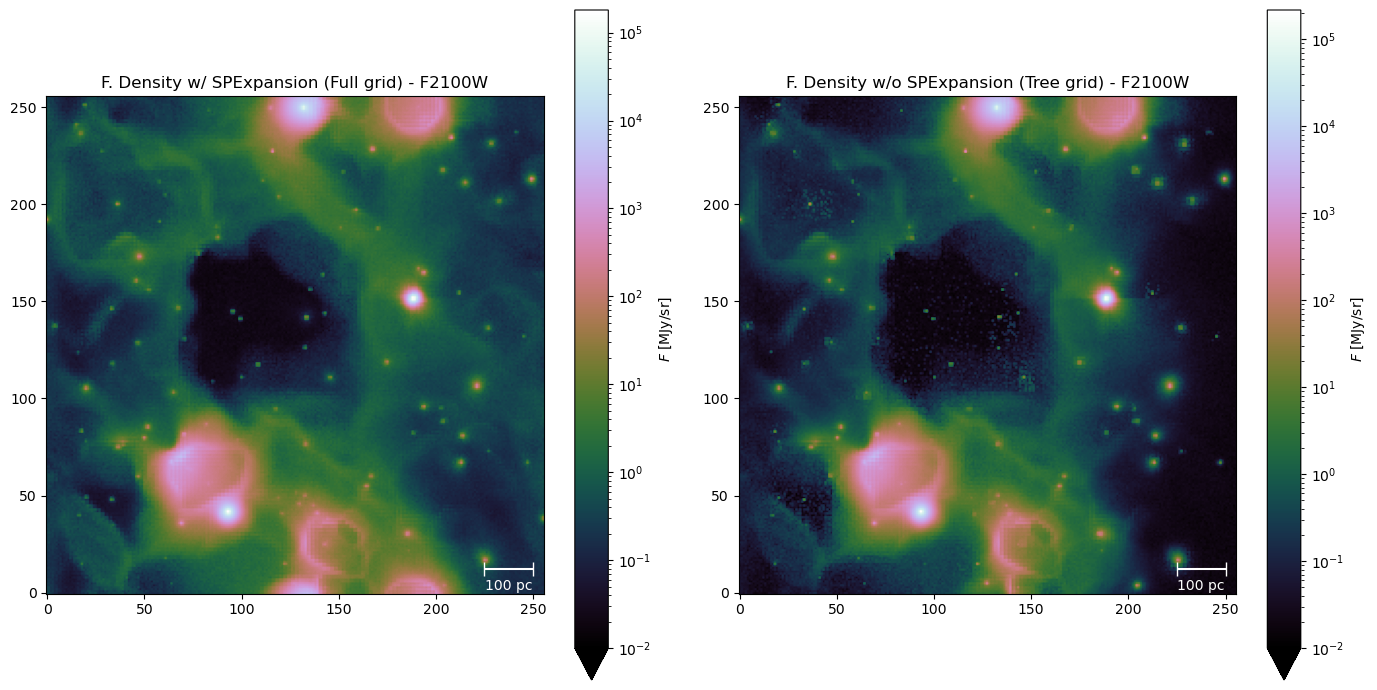

BUNIT with dust: MJy/sr
Range with SPExpansion: 0.0 to 6954.943359375
BUNIT without dust: MJy/sr
Range without SPExpansion: 0.0 to 8449.822265625


In [40]:
with fits.open(f"{output_dir_exp}IRTr3_i0_total.fits") as hdul:
    image_fits_exp = hdul[0].data.astype(np.float64)
    header_exp = hdul[0].header
with fits.open(f"{output_dir_IR}IRTr2_Disk_SB99_i0_total.fits") as hdul:
    image_fits_noexp = hdul[0].data.astype(np.float64)
    header_noexp = hdul[0].header

# [100:200,150:250]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
palette = plt.cm.cubehelix.with_extremes(bad='k')
new_im_exp = np.sum(image_fits_exp[426:452, :, :], axis=0)
im1 = axes[0].imshow(np.squeeze(new_im_exp), cmap=palette, origin='lower', norm=LogNorm(vmin=1e-2, vmax=new_im_exp.max()))
#axes[0].set_xticks(np.arange(0, 101, 10))
#axes[0].set_yticks(np.arange(0, 101, 10))
#axes[0].grid(True)
cbar = plt.colorbar(im1, ax=axes[0], extend='min')
cbar.set_label(r'$F$ [MJy/sr]')
trans = transforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].errorbar(237.5, 0.05, xerr=12.5, color='white', capsize=5, transform=trans)
axes[0].text(237.5, 0.03, '100 pc', color='white', ha='center', va='top', transform=trans)
axes[0].set_title('F. Density w/ SPExpansion (Full grid) - F2100W')

new_im_noexp = np.sum(image_fits_noexp[426:452, :, :], axis=0)
im2 = axes[1].imshow(np.squeeze(new_im_noexp), cmap=palette, origin='lower', norm=LogNorm(vmin=1e-2, vmax=new_im_noexp.max()))
cbar = plt.colorbar(im2, ax=axes[1], extend='min')
cbar.set_label(r'$F$ [MJy/sr]')
trans = transforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)
axes[1].errorbar(237.5, 0.05, xerr=12.5, color='white', capsize=5, transform=trans)
axes[1].text(237.5, 0.03, '100 pc', color='white', ha='center', va='top', transform=trans)
axes[1].set_title('F. Density w/o SPExpansion (Tree grid) - F2100W')

plt.tight_layout()
plt.show()

print(f"BUNIT with dust: {header_exp['BUNIT']}")
print('Range with SPExpansion: ' + str(image_fits_exp[438].min()) + ' to ' + str(image_fits_exp[438].max()))
print(f"BUNIT without dust: {header_noexp['BUNIT']}")
print('Range without SPExpansion: ' + str(image_fits_noexp[438].min()) + ' to ' + str(image_fits_noexp[438].max()))

# ISM phases visualization (optional)

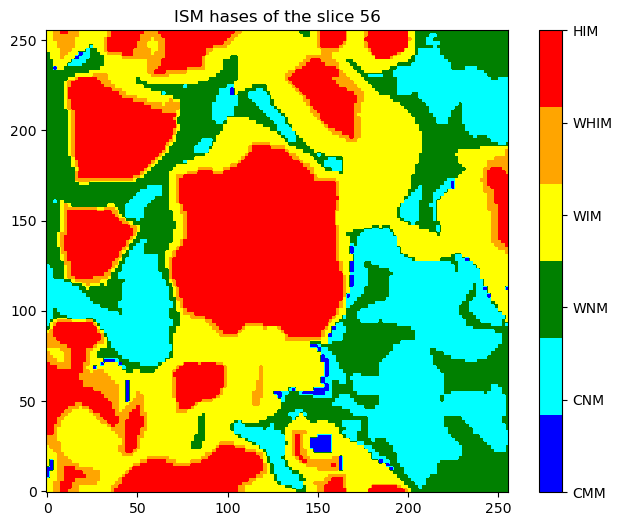

In [21]:
# I can also distinguish amongst the various phases of the ISM with a simple classification,
# which is partially taken from Kim et. al. (2023) "Introducing TIGRESS-NCR. I"
# Normally, I would not use this part of the code, so I did not include this in the main for cycle to create the snapshots to export to SKIRT.

phase_array = []
for i in range(Nx[0]):
    for j in range(Nx[1]):
        for k in range(704, 832):
            temperature_val = (temperature['T'].data)[k, j, i]
            HI_fraction_val = (hydrogen_fraction['xHI'].data)[k, j, i]

            if temperature_val > 5e5:
                cat_val = "HIM"
            elif 3.5e4 < temperature_val <= 5e5:
                cat_val = "WHIM"
            elif 6e3 < temperature_val <= 3.5e4:
                if HI_fraction_val < 0.5:
                    cat_val = "WIM"
                else:
                    cat_val = "WNM"
            elif temperature_val <= 6e3:
                if HI_fraction_val > 0.5:
                    cat_val = "CNM"
                else:
                    cat_val = "CMM"
            phase_array.append([cat_val, HI_fraction_val])
phase_array = np.array(phase_array)

from matplotlib.colors import ListedColormap
category_mapping = {"CMM": 0, "CNM": 1, "WNM": 2, "WIM": 3, "WHIM": 4, "HIM": 5}
colors = ["blue", "cyan", "green", "yellow", "orange", "red"]
cmap = ListedColormap(colors)

plot_phases = (phase_array[:,0].reshape(256, 256, 128))[:,:,56].transpose()

plt.figure(figsize=(8, 6))
plt.imshow(np.vectorize(category_mapping.get)(plot_phases) , cmap=cmap, origin="lower")
cbar = plt.colorbar(ticks=range(len(category_mapping)))
cbar.ax.set_yticklabels(category_mapping.keys())
plt.title("ISM hases of the slice " + str(56))
plt.show()
